In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib

np.random.seed(42)
n = 800

consent_types = ["explicit", "implicit", "none"]
districts = ["Downtown", "Suburban", "Industrial", "Green Zone"]

data = pd.DataFrame({
    "Device_ID": range(1, n+1),
    "Owner_Age": np.random.randint(18, 80, n),
    "District": np.random.choice(districts, n),
    "Consent_Type": np.random.choice(consent_types, n, p=[0.6, 0.3, 0.1]),
    "Vehicle_Count": np.random.randint(0, 200, n),
    "Avg_Speed": np.round(np.random.uniform(10, 80, n), 1),
    "Air_Quality_Index": np.random.randint(10, 300, n),
    "Reported_Incident": np.random.choice([0, 1], n, p=[0.85, 0.15])
})

data.head()

,Device_ID,Owner_Age,District,Consent_Type,Vehicle_Count,Avg_Speed,Air_Quality_Index,Reported_Incident
0,1,56,Green Zone,implicit,171,21.6,48,0
1,2,69,Downtown,explicit,1,71.7,25,0
2,3,46,Green Zone,implicit,101,39.9,31,0
3,4,32,Industrial,explicit,34,21.4,222,0
4,5,60,Downtown,implicit,97,10.9,158,0


In [2]:
def filter_valid_consent(df):
    return df[df["Consent_Type"].isin(["explicit", "implicit"])]

valid_data = filter_valid_consent(data)

print(f"Before filtering: {len(data)} records")
print(f"After filtering: {len(valid_data)} records")

Before filtering: 800 records
After filtering: 723 records


District
Downtown      0.120930
Green Zone    0.129213
Industrial    0.115000
Suburban      0.135266
Name: Reported_Incident, dtype: float64


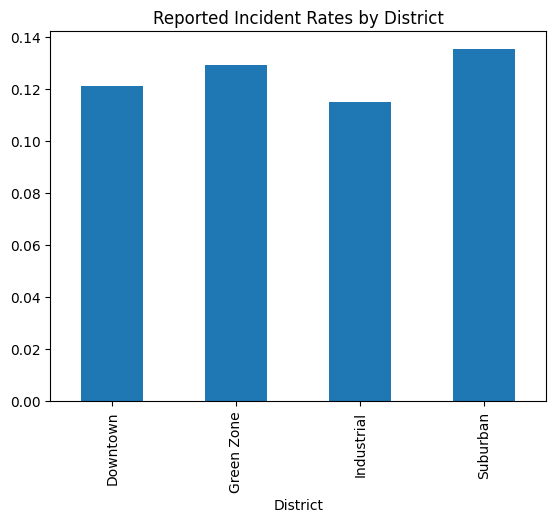

Bias observation: If certain districts have much higher/lower rates, this may be due to uneven sensor placement or socio-economic factors.


In [3]:
incident_rates = data.groupby("District")["Reported_Incident"].mean()
print(incident_rates)

incident_rates.plot(kind="bar", title="Reported Incident Rates by District")
plt.show()

print("Bias observation: If certain districts have much higher/lower rates, this may be due to uneven sensor placement or socio-economic factors.")

In [4]:
traffic_data = data[["District", "Vehicle_Count", "Avg_Speed"]]
traffic_data.head()

print("We removed personal and unrelated attributes. This reduces privacy risk and unnecessary exposure of sensitive info.")

We removed personal and unrelated attributes. This reduces privacy risk and unnecessary exposure of sensitive info.


In [5]:
data["Device_PseudoID"] = data["Device_ID"].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())
data_anonymized = data.drop(columns=["Device_ID"])
data_anonymized.head()

,Owner_Age,District,Consent_Type,Vehicle_Count,Avg_Speed,Air_Quality_Index,Reported_Incident,Device_PseudoID
0,56,Green Zone,implicit,171,21.6,48,0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...
1,69,Downtown,explicit,1,71.7,25,0,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...
2,46,Green Zone,implicit,101,39.9,31,0,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...
3,32,Industrial,explicit,34,21.4,222,0,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...
4,60,Downtown,implicit,97,10.9,158,0,ef2d127de37b942baad06145e54b0c619a1f22327b2ebb...


In [6]:
# Auxiliary dataset simulating publicly available demographic info
aux_data = data[["Owner_Age", "District"]].sample(100, random_state=1)

# Attempt to re-identify
matches = pd.merge(data_anonymized, aux_data, on=["Owner_Age", "District"])
match_rate = len(matches) / len(aux_data) * 100

print(f"Potential re-identifications via linkage: {match_rate:.2f}%")

Potential re-identifications via linkage: 428.00%


In [7]:
access_control = pd.DataFrame({
    "Field": ["Device_ID", "District", "Air_Quality_Index", "Owner_Age", "Reported_Incident"],
    "Admin": ["Read/Write"]*5,
    "Analyst": ["No Access", "Read", "Read", "Read", "Read"],
    "Public": ["No Access", "Read", "Read", "No Access", "Aggregated Only"]
})

print(access_control)
print("\nResponsibilities of Data Steward: Ensuring policy compliance, approving data access, monitoring privacy violations, and managing data lifecycle.")

               Field       Admin    Analyst           Public
0          Device_ID  Read/Write  No Access        No Access
1           District  Read/Write       Read             Read
2  Air_Quality_Index  Read/Write       Read             Read
3          Owner_Age  Read/Write       Read        No Access
4  Reported_Incident  Read/Write       Read  Aggregated Only

Responsibilities of Data Steward: Ensuring policy compliance, approving data access, monitoring privacy violations, and managing data lifecycle.


In [8]:
# Quality check
print("Missing values:\n", data.isnull().sum())
print("Out of range AQI count:", ((data["Air_Quality_Index"] < 0) | (data["Air_Quality_Index"] > 500)).sum())

# Transformation log simulation
lineage_log = []
lineage_log.append({"step": "initial_load", "records": len(data)})
lineage_log.append({"step": "filter_valid_consent", "records": len(valid_data)})
print("\nLineage Log:", lineage_log)

Missing values:
 Device_ID            0
Owner_Age            0
District             0
Consent_Type         0
Vehicle_Count        0
Avg_Speed            0
Air_Quality_Index    0
Reported_Incident    0
Device_PseudoID      0
dtype: int64
Out of range AQI count: 0

Lineage Log: [{'step': 'initial_load', 'records': 800}, {'step': 'filter_valid_consent', 'records': 723}]


In [9]:
# Aggregated dataset
agg_data = data.groupby("District").agg({
    "Vehicle_Count": "mean",
    "Avg_Speed": "mean",
    "Air_Quality_Index": "mean",
    "Reported_Incident": "mean"
}).reset_index()

print("Aggregated dataset ready for sharing:\n", agg_data)

def approve_request(request_type):
    if request_type in ["aggregated", "anonymized"]:
        return "Approved"
    return "Denied"

for r in ["aggregated", "anonymized", "full"]:
    print(f"Request {r}: {approve_request(r)}")

Aggregated dataset ready for sharing:
      District  Vehicle_Count  Avg_Speed  Air_Quality_Index  Reported_Incident
0    Downtown     103.930233  44.347907         148.883721           0.120930
1  Green Zone     100.011236  44.689326         160.578652           0.129213
2  Industrial     105.100000  46.230500         148.280000           0.115000
3    Suburban      95.729469  43.542512         163.362319           0.135266
Request aggregated: Approved
Request anonymized: Approved
Request full: Denied


In [10]:
# Consent compliance
consent_ratio = len(valid_data) / len(data)
# Incident disparity
inc_disparity = incident_rates.max() - incident_rates.min()

print(f"Consent compliance: {consent_ratio:.2f}")
print(f"Incident disparity: {inc_disparity:.2f}")

if consent_ratio < 0.9:
    print("⚠ ALERT: Consent compliance below threshold.")
if inc_disparity > 0.15:
    print("⚠ ALERT: High disparity in incident reporting detected by district.")

print("\nEscalation Steps: 1) Flag issue to Data Steward, 2) Investigate causes, 3) Apply corrective measures, 4) Report to oversight body.")

Consent compliance: 0.90
Incident disparity: 0.02

Escalation Steps: 1) Flag issue to Data Steward, 2) Investigate causes, 3) Apply corrective measures, 4) Report to oversight body.
